# Virally Suppression Calculation
**Description:** This script prepares the lab data and creates the several virally suppressed target based on 1000 cp/ml and undetectable 40cp/ml.

**Author:** Marang Mutloatse

**Version:** 0.0.1

**Status:** Development

# Import Libraries

In [1]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
sys.path.insert(0,package_path + '/src/')
import yaml
from hiv_support_package import visit_features, viral_load_targets
from datetime import timedelta
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Loading Functions

In [2]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [3]:
input_root = config['rise_files']['raw_data_path']
input_file = config['rise_files']['raw_lab_file']
lab_input = input_root + input_file 
print(lab_input)

/data/rise_data/All LaboratoryData_Flat File.csv


In [4]:
df = pd.read_csv(lab_input,low_memory=False)

## Working Functions

In [5]:
def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")

def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 
            
def otherise(df): 
    if df['Labtest Name']=='Viral Load':
        return 'Viral Load'
    elif df['Labtest Name']=='CD4':
        return 'CD4'
    elif df['Labtest Name']=='Lymphocytes':
        return 'Lymphocytes'
    elif df['Labtest Name']=='PCV':
        return 'PCV'
    elif df['Labtest Name']=='WB4':
        return 'WB4'
    else:
        return 'Other Tests'
    
def under_represented(df, threshold=0.99):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
        if not under_rep:
            print("No underrepresented features")
        else:
            if TARGET in under_rep:
                print("The target variable is underrepresented, consider rebalancing")
                under_rep.remove(TARGET)
            print(str(under_rep) + " underrepresented")
        return under_rep

def categorical_bar_plot(df):
    if df is not None:
        for i in df.columns[df.dtypes==object]:
            df[i].value_counts().plot(kind='bar')
            plt.title(i)
            plt.show()
            
def plot_line_graph(df, x_variable: str,y_variable: str,x_label: str,y_label: str,hue_name,style):
    ax = sns.lineplot(x = x_variable,y=y_variable,data=df,hue=hue_name,ci=None,markers=True,style=style)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title('Comparison Plot: Trend of Average Monthly Virally Suppressed')
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

def plot_boxplot_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str,title: str,hue=None):
    ax = sns.boxplot(x = x_variable,y=y_variable,data=df,hue=None)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title(title)
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})

def plot_violinplot_graph(df,x_variable: str,y_variable: str,x_label: str,y_label: str,title: str):
    ax = sns.violinplot(x = x_variable,y=y_variable,data=df)
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set_title(title)
    plt.xticks(rotation=60)
    plt.legend(loc='upper left')
    sns.set(rc={'figure.figsize':(10,10)})
            
def vl_counts_df(df,target_column):
    if df is not None:
        try:
            df_counts = df.groupby(['EF_TAKEN_YEAR','EF_TAKEN_MONTH','State'])[target_column].value_counts()
            df_counts = df_counts.rename('VL_COUNTS')
            df_counts = df_counts.reset_index()
            return df_counts
        except Exception as e:
            print(f"Exception on plotting counts with error: {e}")

# Initial Data Check

In [6]:
print_num_rows_cols(df,'Labs')

Labs data has 13 columns and 813244 rows.


In [7]:
check_null_values(df)

There are 6 columns that have missing values


Missing Values  % of Total Values
RESULTPC                740919               91.1
COMMENT                 632149               77.7
LABNO                   321830               39.6
resultab                 27706                3.4
DATE_COLLECTED            5919                0.7
DATE_REPORTED              839                0.1

In [8]:
print('Patients:',df['PATIENT_ID'].nunique())

Patients: 103401


In [9]:
df['Labtest Name'] = df['Labtest Name'].dropna()
df['Labtest Name'].describe()

count         813244
unique            37
top       Viral Load
freq          209459
Name: Labtest Name, dtype: object

In [10]:
# Filter for Viral Load Tests
df = df.loc[df['Labtest Name'].isin(['Viral Load'])]

## Data Cleaning

In [11]:
# Ensure target column is string format
df['resultab'] = df['resultab'].astype(str)

In [12]:
# Not reallyy necessary
# ind_col = df['resultab'].str.contains("<")
# ind1_col = df['resultab'].str.contains("<40 ")
# und_col = df['resultab'].str.contains("not detec|not det|nt det|nt dec|nt detec|nd|undetected|tnd|T N D|TND|TDN|N.D.|ND|N/D|NOT DETECT") 
# df['EF_LEVEL_INDICATOR'] = ind_col.astype(int)
# df['EF_LEVEL_INDICATOR_40'] = ind1_col.astype(int)
# df['EF_UNDETECTED_RESULT'] = und_col.astype(int)

In [13]:
df.loc[(df['resultab'] == '<400') | (df['resultab'] == ' <400 ') ,'resultab'] = '399'
df.loc[(df['resultab'] == '<40') | (df['resultab'] == '<40') ,'resultab'] = '40'
df.loc[(df['resultab'] == '<400 cp/ml ') | (df['resultab'] == '<400cp/ml') | (df['resultab'] == '<400 C/ML'),'resultab'] = '400'

In [14]:
df.loc[df['resultab'].str.contains("not detec|not det|nt det|nt dec|nt detec|nd|undetected|tnd|T N D|TND|TDN|N.D.|ND|N/D|NOT DETECT"),'resultab']='0'

In [15]:
# coercing nan strings, to nan values
df.loc[(df['resultab'] == 'nan') | (df['resultab'] == 'na') ,'resultab'] = pd.np.nan

In [16]:
#  extracting viral load in integer and floats
df['resultab'] = df['resultab'].str.extract(r'(\d+\.\d+|\d+)', expand=False)

In [17]:
# cleaning up trailing whitespaces
df['resultab'] = df['resultab'].replace(r'^\s*$', pd.np.nan, regex=True)

In [73]:
df['resultab'].sample(10)

93614      22336.0
408698      7150.0
273156    153570.0
367459        40.0
361729        40.0
115927        40.0
251925        40.0
780088        40.3
237663       190.0
391218        69.0
Name: resultab, dtype: float64

In [18]:
check_null_values(df)

There are 5 columns that have missing values


Missing Values  % of Total Values
RESULTPC               198685               94.9
LABNO                   42524               20.3
COMMENT                 36542               17.4
resultab                  779                0.4
DATE_REPORTED             772                0.4

##  Deduplicating Data

In [19]:
df.duplicated().sum()

0

In [20]:
print(f"There are {df.loc[:, df.columns != 'LABORATORY_ID'].duplicated(subset=['DATE_COLLECTED','PATIENT_ID','DATE_REPORTED','resultab']).sum()} duplicate rows based on the DATE_COLLECTED,PATIENT_ID,DATE_REPORTED and resultab fields")

There are 6290 duplicate rows based on the DATE_COLLECTED,PATIENT_ID,DATE_REPORTED and resultab fields


In [21]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','DATE_REPORTED','DATE_COLLECTED','resultab'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 209459 rows
 
After deduplication the dataframe has 203169 rows


In [22]:
# Choosing notnull(0)
df = df[df['resultab'].notnull()]
df['resultab'] = df['resultab'].astype(float)

In [23]:
print(f"After drop null values the dataframe has {df.shape[0]} rows")

After drop null values the dataframe has 202408 rows


## Data Preparation

In [24]:
df['DATE_COLLECTED'] = pd.to_datetime(df['DATE_COLLECTED'],format="%d/%m/%Y",errors='coerce')
df['DATE_REPORTED'] = pd.to_datetime(df['DATE_REPORTED'],format="%d/%m/%Y",errors='coerce')

In [25]:
print(df[df['Labtest Name'] =='Viral Load']['resultab'].dropna().value_counts(
    bins=[0,1, 40, 200,500,1000,1600,2000,3000,1000000000]).sort_index())
n = len(df)
print(df.shape)
df = df[~((df['Labtest Name']=='Viral Load') & (df['resultab'] > 10000000))]
n = n - len(df)
print(df.shape, n, 'Tests removed removed')

(-0.001, 1.0]              13627
(1.0, 40.0]               112191
(40.0, 200.0]              28348
(200.0, 500.0]             10760
(500.0, 1000.0]             5393
(1000.0, 1600.0]            2736
(1600.0, 2000.0]            1217
(2000.0, 3000.0]            2056
(3000.0, 1000000000.0]     26080
Name: resultab, dtype: int64
(202408, 13)
(202399, 13) 9 Tests removed removed


In [26]:
df = df.sort_values(by =['PATIENT_ID','DATE_COLLECTED']) 

In [27]:
df.shape

(202399, 13)

In [28]:
df = df[df['DATE_REPORTED'].notnull()]

In [29]:
df.shape

(201808, 13)

### Date Time conversion and Feature Creation

In [30]:
# changed from collected to reported or vice-versa
df['EF_TAKEN_YEAR'] = df['DATE_REPORTED'].dt.year
df['EF_TAKEN_MONTH'] = df['DATE_REPORTED'].dt.month

In [31]:
# Inclusion years
df = df[df['EF_TAKEN_YEAR']>2015]
df = df[df['EF_TAKEN_YEAR']<2021]

# Target Creation

In [32]:
# Generate virally undetectable target
df = viral_load_targets.virally_undetectable_target(df, 'resultab', 40, 'Labtest Name', 'Viral Load')
df = viral_load_targets.vl_categorization_rise_target(df, 'resultab', 40, 1000)

# Generate virally suppressed target
df = viral_load_targets.virally_suppressed_target(df, 'resultab', 1000, 'Labtest Name', 'Viral Load')
df = viral_load_targets.virally_suppressed_target(df, 'resultab', 400, 'Labtest Name', 'Viral Load')

# Generate virally unsuppressed target
df = viral_load_targets.virally_unsuppressed_target(df, 'resultab', 1000, 'Labtest Name', 'Viral Load')
df = viral_load_targets.virally_unsuppressed_target(df, 'resultab', 400, 'Labtest Name', 'Viral Load')

In [33]:
# Calculate the RISE Target bands (below =< 40cp/ml & 40 - 1000 cp/ml & > 1000 cp/ml)
target_definitions = [(df['resultab'] <= 40),(df['resultab'] > 40) & (df['resultab'] < 1000),(df['resultab'] >=1000)]
target_values = ['Undetectable','Suppressed','Unsuppressed']
df['OUTCOME_RISE_VL_CATEGORIZATION'] = np.select(target_definitions,target_values)

## Calculating the number of patients

In [34]:
num_labs = df[['PATIENT_ID','DATE_REPORTED']].groupby('PATIENT_ID').count().reset_index().groupby('DATE_REPORTED').count().reset_index().sort_values('DATE_REPORTED')

In [35]:
display(df.groupby(['EF_TAKEN_YEAR','EF_TAKEN_MONTH'])['DATE_REPORTED'].count().sort_index().to_frame().style)

## VL Suppressed Counts

In [36]:
df_counts = df.groupby(['EF_TAKEN_YEAR','EF_TAKEN_MONTH','State','T_VL_SUPP_1000'])['PATIENT_ID'].nunique()
df_counts = df_counts.rename('VL_COUNTS')
df_counts = df_counts.reset_index()

## Viral Load RISE Categorization Analysis

### Patient Level

In [37]:
round(df['OUTCOME_RISE_VL_CATEGORIZATION'].value_counts(normalize=True),2)

Undetectable    0.57
Suppressed      0.24
Unsuppressed    0.19
Name: OUTCOME_RISE_VL_CATEGORIZATION, dtype: float64

In [38]:
df_patient = df.groupby(['EF_TAKEN_YEAR','State','OUTCOME_RISE_VL_CATEGORIZATION']).agg({'PATIENT_ID':lambda x: x.nunique()}).reset_index()

In [39]:
df_patient_total = df_patient.groupby(['EF_TAKEN_YEAR','State','OUTCOME_RISE_VL_CATEGORIZATION']).agg({'PATIENT_ID': 'sum'})

In [40]:
df_patient_pcts = df_patient_total.groupby(level=[0,1]).apply(lambda x:
                                                 round(100 * x / float(x.sum()),2))

df_patient_pcts

PATIENT_ID
EF_TAKEN_YEAR State       OUTCOME_RISE_VL_CATEGORIZATION            
2016          Adamawa     Undetectable                         33.33
                          Unsuppressed                         66.67
              Akwa Ibom   Suppressed                           20.47
                          Undetectable                         50.40
                          Unsuppressed                         29.13
              Cross River Suppressed                           17.82
                          Undetectable                         71.29
                          Unsuppressed                         10.89
              Niger       Suppressed                           15.62
                          Undetectable                         68.75
                          Unsuppressed                         15.62
2017          Adamawa     Suppressed                           24.81
                          Undetectable                         52.55
                          Unsuppressed                         22.64
              Akwa Ibom   Suppressed                           19.10
                          Undetectable                         52.56
                          Unsuppressed                         28.34
              Cross River Suppressed                           27.59
                          Undetectable                         51.44
                          Unsuppressed                         20.96
              Niger       Suppressed                           32.89
                          Undetectable                         28.38
                          Unsuppressed                         38.73
2018          Adamawa     Suppressed                           23.69
                          Undetectable                         51.88
                          Unsuppressed                         24.42
              Akwa Ibom   Suppressed                           18.98
                          Undetectable                         53.01
                          Unsuppressed                         28.01
              Cross River Suppressed                           36.73
                          Undetectable                         40.07
                          Unsuppressed                         23.20
              Niger       Suppressed                           24.66
                          Undetectable                         42.07
                          Unsuppressed                         33.27
2019          Adamawa     Suppressed                           27.19
                          Undetectable                         55.31
                          Unsuppressed                         17.50
              Akwa Ibom   Suppressed                           23.34
                          Undetectable                         56.33
                          Unsuppressed                         20.33
              Cross River Suppressed                           39.56
                          Undetectable                         44.70
                          Unsuppressed                         15.73
              Niger       Suppressed                           32.15
                          Undetectable                         37.10
                          Unsuppressed                         30.76
2020          Adamawa     Suppressed                           38.89
                          Undetectable                         50.75
                          Unsuppressed                         10.37
              Akwa Ibom   Suppressed                           18.07
                          Undetectable                         69.47
                          Unsuppressed                         12.46
              Cross River Suppressed                           21.49
                          Undetectable                         69.33
                          Unsuppressed                          9.18
              Niger       Suppressed                    

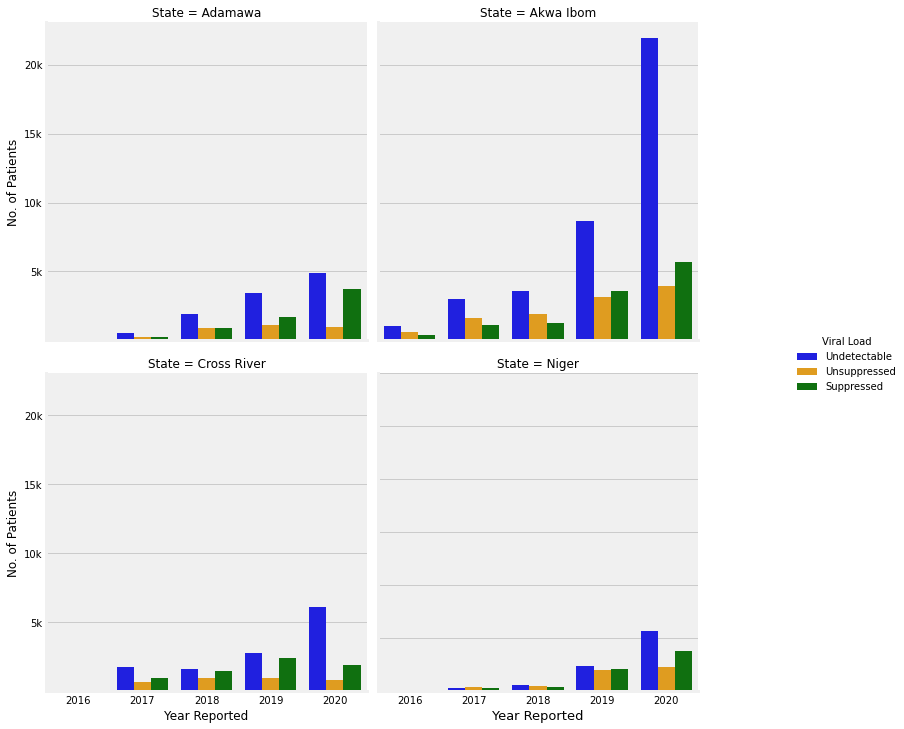

In [41]:
fig = sns.catplot(x="EF_TAKEN_YEAR",y="PATIENT_ID",hue="OUTCOME_RISE_VL_CATEGORIZATION",kind="bar",data = df_patient,col="State",col_wrap=2,palette=sns.color_palette(['blue', 'orange','green']))
plt.yticks(ticks=[5000,10000,15000,20000,25000,30000], labels=['5k','10k','15k','20k','25k','30k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)

fig._legend.texts[2].set_text("Suppressed")
fig._legend.texts[0].set_text("Undetectable")
fig._legend.texts[1].set_text("Unsuppressed")
fig._legend.set_title("Viral Load")
fig.set_axis_labels("Year Reported", "No. of Patients")
sns.set(rc={'figure.figsize':(8,8)})

### Aggregated Lab Test Level

In [42]:
df_lab = df.groupby(['EF_TAKEN_YEAR','State','OUTCOME_RISE_VL_CATEGORIZATION']).agg({'OUTCOME_RISE_VL_CATEGORIZATION': 'count'})

In [43]:
df_lab_pcts = df_lab.groupby(level=[0,1]).apply(lambda x:
                                                 round(100 * x / float(x.sum()),2))
df_lab_pcts

OUTCOME_RISE_VL_CATEGORIZATION
EF_TAKEN_YEAR State       OUTCOME_RISE_VL_CATEGORIZATION                                
2016          Adamawa     Undetectable                                             40.00
                          Unsuppressed                                             60.00
              Akwa Ibom   Suppressed                                               20.37
                          Undetectable                                             51.51
                          Unsuppressed                                             28.12
              Cross River Suppressed                                               17.12
                          Undetectable                                             72.97
                          Unsuppressed                                              9.91
              Niger       Suppressed                                               14.71
                          Undetectable                                             70.59
                          Unsuppressed                                             14.71
2017          Adamawa     Suppressed                                               24.34
                          Undetectable                                             52.70
                          Unsuppressed                                             22.96
              Akwa Ibom   Suppressed                                               17.88
                          Undetectable                                             53.05
                          Unsuppressed                                             29.08
              Cross River Suppressed                                               26.66
                          Undetectable                                             52.02
                          Unsuppressed                                             21.31
              Niger       Suppressed                                               32.88
                          Undetectable                                             28.05
                          Unsuppressed                                             39.07
2018          Adamawa     Suppressed                                               22.76
                          Undetectable                                             51.79
                          Unsuppressed                                             25.45
              Akwa Ibom   Suppressed                                               17.27
                          Undetectable                                             53.22
                          Unsuppressed                                             29.52
              Cross River Suppressed                                               35.20
                          Undetectable                                             40.27
                          Unsuppressed                                             24.53
              Niger       Suppressed                                               23.58
                          Undetectable                                             42.55
                          Unsuppressed                                             33.87
2019          Adamawa     Suppressed                                               25.75
                          Undetectable                                             57.44
                          Unsuppressed                                             16.81
              Akwa Ibom   Suppressed                                               22.13
                          Undetectable                                             57.75
                          Unsuppressed                                             20.11
              Cross River Suppressed                                               38.04
                          Undetectable                                             45.80
                          Unsuppressed               

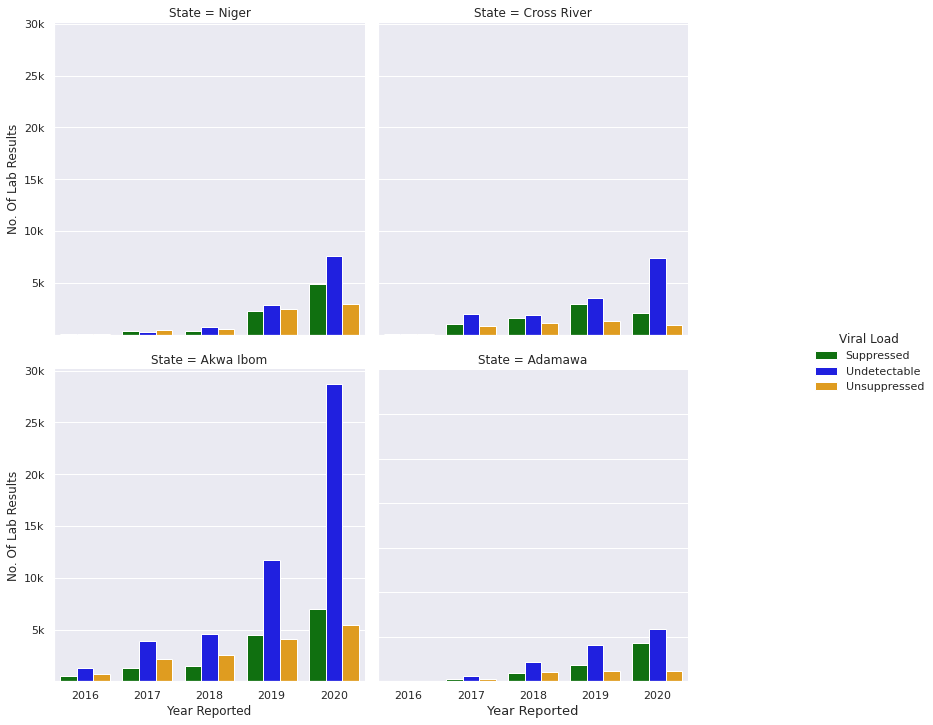

In [44]:
fig = sns.catplot(x="EF_TAKEN_YEAR",hue="OUTCOME_RISE_VL_CATEGORIZATION",kind="count",data = df,col="State",col_wrap=2,palette=sns.color_palette(['green', 'blue','orange']))
plt.yticks(ticks=[5000,10000,15000,20000,25000,30000,35000], labels=['5k','10k','15k','20k','25k','30k','35k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)

fig._legend.texts[0].set_text("Suppressed")
fig._legend.texts[1].set_text("Undetectable")
fig._legend.texts[2].set_text("Unsuppressed")
fig._legend.set_title("Viral Load")
fig.set_axis_labels("Year Reported", "No. Of Lab Results")
sns.set(rc={'figure.figsize':(8,8)})

### < 1 000 cp/ml

In [45]:
df[df['T_VL_SUPP_1000']==True].groupby(['EF_TAKEN_YEAR','EF_TAKEN_MONTH','State','Facility Name'])['PATIENT_ID'].nunique()

EF_TAKEN_YEAR  EF_TAKEN_MONTH  State        Facility Name                             
2016           1               Akwa Ibom    Etim Ekpo General Hospital                     7
                                            Ikot Ekpene General Hospital                  13
                                            Ukana Iba St Josephs rehabilitation Center     4
                               Cross River  Ogoja Catholic Maternity Hospital              3
                               Niger        Federal Medical Centre - Bida                  1
                                                                                          ..
2020           12              Niger        MCH Gulu                                      15
                                            Rural Hosp                                    21
                                            Rural Hosp- Auna                              10
                                            Shehu Shagari General Hospital N

In [46]:
df_vl_counts = vl_counts_df(df,'T_VL_SUPP_1000')
df_vl_counts_ada = df_vl_counts[df_vl_counts['State'] == 'Adamawa']
df_vl_counts_akw = df_vl_counts[df_vl_counts['State'] == 'Akwa Ibom']
df_vl_counts_crs = df_vl_counts[df_vl_counts['State'] == 'Cross River']
df_vl_counts_nig = df_vl_counts[df_vl_counts['State'] == 'Niger']

df_vl_patient_ada = df_counts[df_counts['State'] == 'Adamawa']
df_vl_patient_akw = df_counts[df_counts['State'] == 'Akwa Ibom']
df_vl_patient_crs = df_counts[df_counts['State'] == 'Cross River']
df_vl_patient_nig = df_counts[df_counts['State'] == 'Niger']

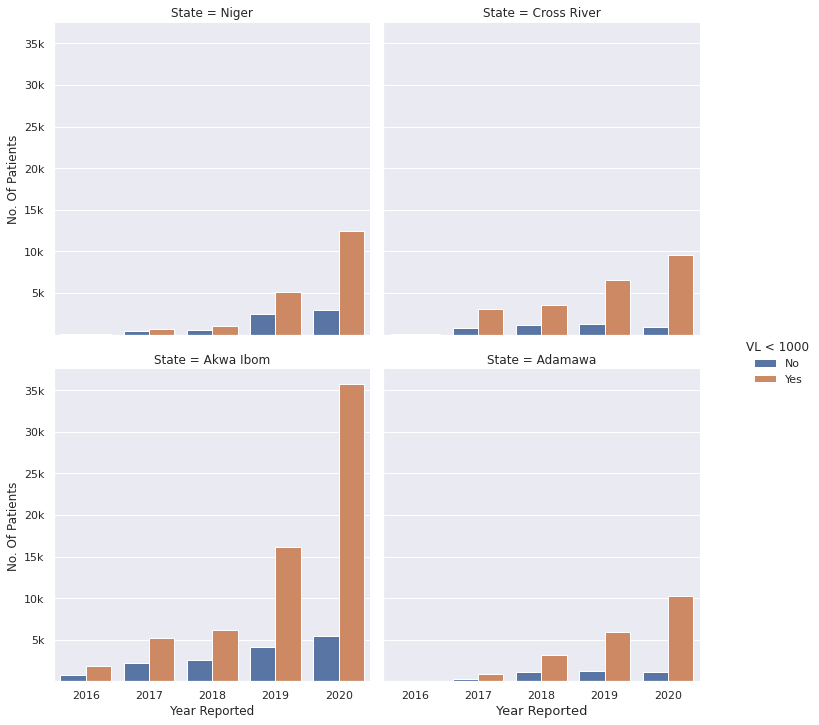

In [47]:
fig = sns.catplot(x="EF_TAKEN_YEAR",hue="T_VL_SUPP_1000",kind="count",data = df,col="State",col_wrap=2)
plt.yticks(ticks=[5000,10000,15000,20000,25000,30000,35000], labels=['5k','10k','15k','20k','25k','30k','35k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)

fig._legend.texts[0].set_text("No")
fig._legend.texts[1].set_text("Yes")
fig._legend.set_title("VL < 1000")
fig.set_axis_labels("Year Reported", "No. Of Patients")
sns.set(rc={'figure.figsize':(8,8)})
plt.savefig("../Figures/lab_result.png",transparent=True,bbox_inches="tight")

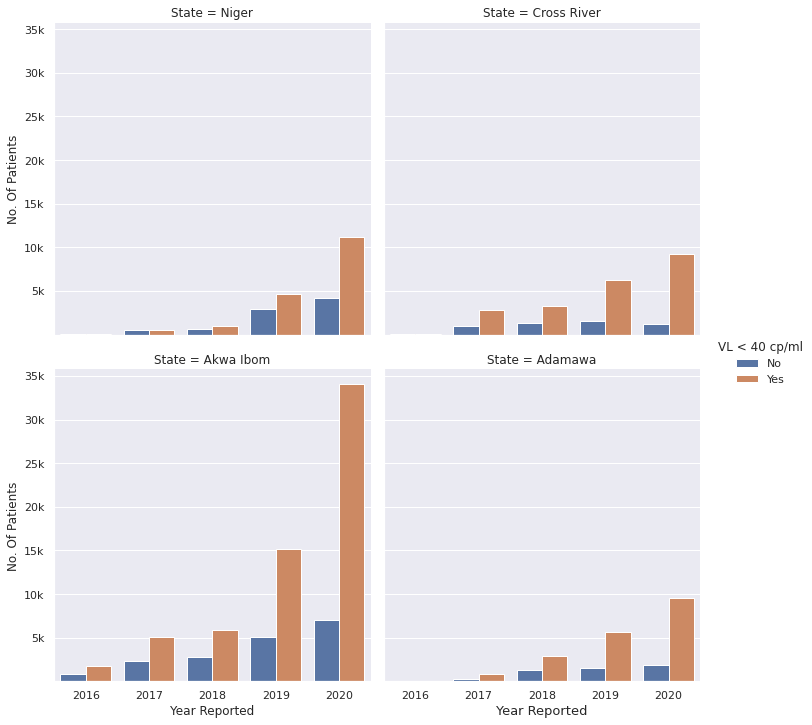

In [48]:
fig = sns.catplot(x="EF_TAKEN_YEAR",hue="T_VL_SUPP_400",kind="count",data = df,col="State",col_wrap=2)
plt.yticks(ticks=[5000,10000,15000,20000,25000,30000,35000], labels=['5k','10k','15k','20k','25k','30k','35k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
fig._legend.texts[0].set_text("No")
fig._legend.texts[1].set_text("Yes")
fig._legend.set_title("VL < 40 cp/ml")
fig.set_axis_labels("Year Reported", "No. Of Patients")
sns.set(rc={'figure.figsize':(8,8)})
plt.savefig("../Figures/lab_result.png",transparent=True,bbox_inches="tight")

In [49]:
df_count_maz = df[df['T_VL_SUPP_1000']==True].groupby(['State','EF_TAKEN_YEAR'])['PATIENT_ID'].count()

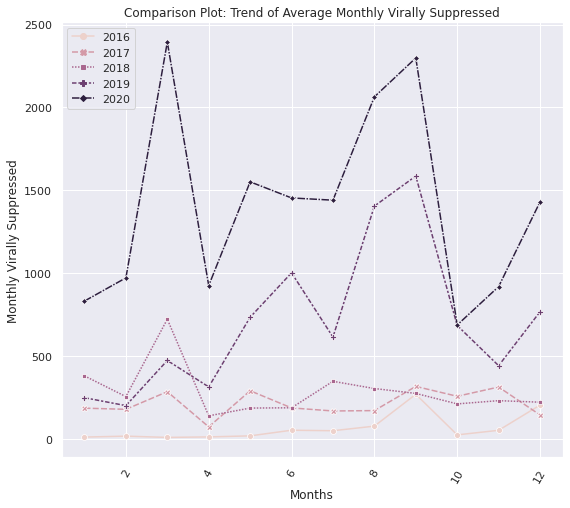

In [50]:
plot_line_graph(df_vl_counts.query("T_VL_SUPP_1000 == 1"),'EF_TAKEN_MONTH','VL_COUNTS','Months','Monthly Virally Suppressed','EF_TAKEN_YEAR','EF_TAKEN_YEAR')

### <400 cp/ml

In [51]:
df_vl_counts = vl_counts_df(df,'T_VL_SUPP_400')

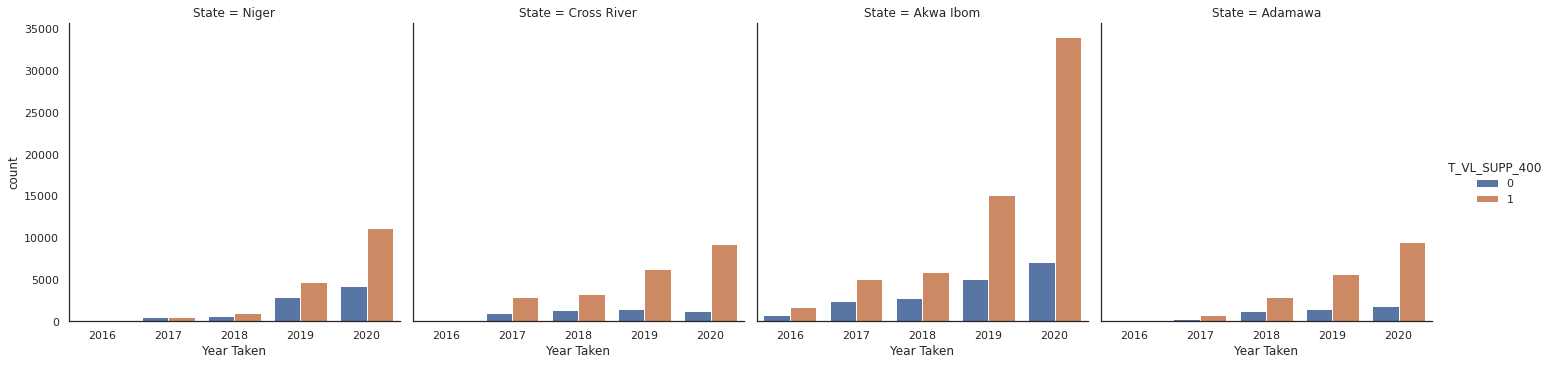

In [52]:
with sns.axes_style("white"): 
    ax = sns.catplot(x="EF_TAKEN_YEAR",hue="T_VL_SUPP_400",kind="count",data = df,col="State")
    ax.set(xlabel='Year Taken')
    sns.set(rc={'figure.figsize':(10,10)})

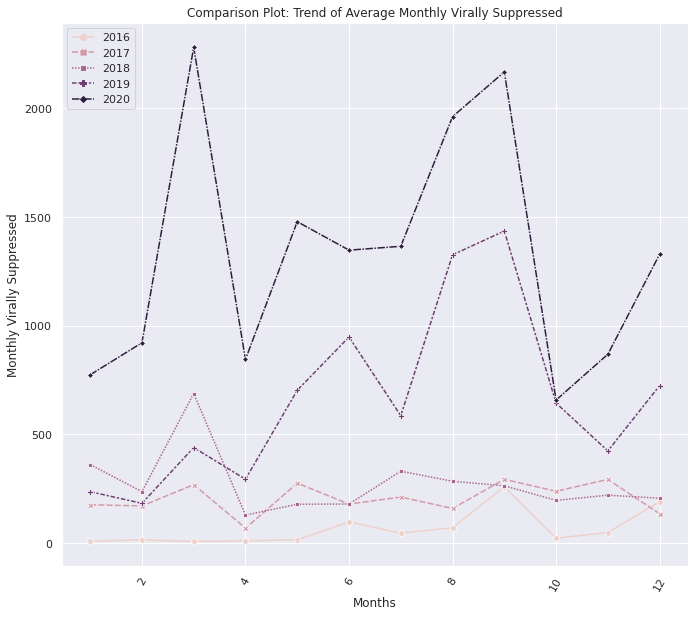

In [53]:
plot_line_graph(df_vl_counts.query("T_VL_SUPP_400 == 1"),'EF_TAKEN_MONTH','VL_COUNTS','Months','Monthly Virally Suppressed','EF_TAKEN_YEAR','EF_TAKEN_YEAR')

### <40 cp/ml

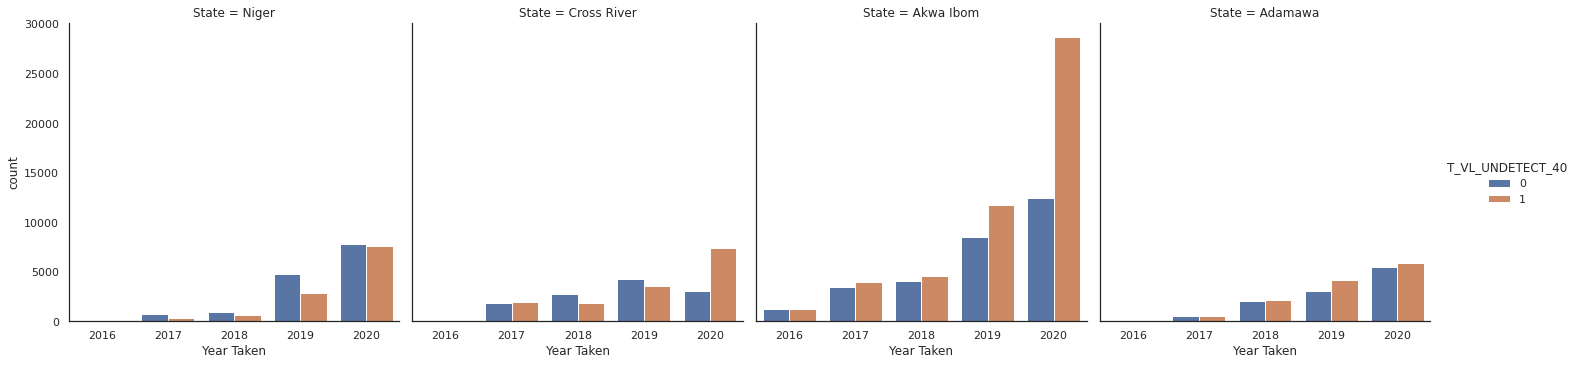

In [54]:
with sns.axes_style("white"): 
    ax = sns.catplot(x="EF_TAKEN_YEAR",hue="T_VL_UNDETECT_40",kind="count",data = df,col="State")
    ax.set(xlabel='Year Taken')
    sns.set(rc={'figure.figsize':(10,10)})

## VL Suppressed Rates

In [55]:
vl_rates = df.groupby(['EF_TAKEN_YEAR','EF_TAKEN_MONTH','State','Facility Name','L.G.A'])['T_VL_SUPP_1000'].value_counts(normalize=True)
vl_rates = vl_rates.rename('VL_RATE')
vl_rates = vl_rates.reset_index()
vl_rates['VL_RATES_PERCENTAGE'] = 100.*vl_rates['VL_RATE']

In [56]:
print(vl_rates[vl_rates['T_VL_SUPP_1000']==1][[
    'EF_TAKEN_YEAR',  'EF_TAKEN_MONTH', 'VL_RATE','VL_RATES_PERCENTAGE']].tail(10))

      EF_TAKEN_YEAR  EF_TAKEN_MONTH   VL_RATE  VL_RATES_PERCENTAGE
4534           2020              12  0.812500            81.250000
4536           2020              12  0.793103            79.310345
4538           2020              12  0.853659            85.365854
4540           2020              12  0.822064            82.206406
4542           2020              12  1.000000           100.000000
4543           2020              12  1.000000           100.000000
4544           2020              12  0.875000            87.500000
4546           2020              12  0.916667            91.666667
4548           2020              12  0.800000            80.000000
4550           2020              12  0.830986            83.098592


In [57]:
df_vl = vl_rates[vl_rates['T_VL_SUPP_1000']==1][[
    'State','Facility Name','L.G.A','EF_TAKEN_YEAR',  'EF_TAKEN_MONTH', 'VL_RATE','VL_RATES_PERCENTAGE']]

In [58]:
df_vl_state_mean = round(df_vl.groupby('State')['VL_RATES_PERCENTAGE'].mean(),2)
df_vl_state_median = round(df_vl.groupby('State')['VL_RATES_PERCENTAGE'].median(),2)
df_vl_lga_mean = round(df_vl.groupby('L.G.A')['VL_RATES_PERCENTAGE'].mean(),2)
df_vl_lga_median = round(df_vl.groupby('L.G.A')['VL_RATES_PERCENTAGE'].median(),2)
df_vl_facility_mean = round(df_vl.groupby('Facility Name')['VL_RATES_PERCENTAGE'].mean(),2)
df_vl_facility_median = round(df_vl.groupby('Facility Name')['VL_RATES_PERCENTAGE'].median(),2)
df_vl_year_mean = round(df_vl.groupby('EF_TAKEN_YEAR')['VL_RATES_PERCENTAGE'].mean(),2)
df_vl_year_median = round(df_vl.groupby('EF_TAKEN_YEAR')['VL_RATES_PERCENTAGE'].median(),2)
df_vl_month_mean = round(df_vl.groupby('EF_TAKEN_MONTH')['VL_RATES_PERCENTAGE'].mean(),2)
df_vl_month_median = round(df_vl.groupby('EF_TAKEN_MONTH')['VL_RATES_PERCENTAGE'].median(),2)

In [59]:
df_vl_year_mean = df_vl_year_mean.rename('AVG_VL_RATE')
df_vl_year_mean=df_vl_year_mean.reset_index()
df_vl_year_mean

EF_TAKEN_YEAR  AVG_VL_RATE
0           2016        81.28
1           2017        75.53
2           2018        76.14
3           2019        77.19
4           2020        86.69

In [60]:
df_vl_month_mean = df_vl_month_mean.rename('AVG_VL_RATE')
df_vl_month_mean=df_vl_month_mean.reset_index()
df_vl_month_mean

EF_TAKEN_MONTH  AVG_VL_RATE
0                1        80.29
1                2        78.51
2                3        79.03
3                4        81.25
4                5        81.44
5                6        79.41
6                7        79.36
7                8        82.02
8                9        80.64
9               10        80.25
10              11        81.60
11              12        81.52

In [61]:
df_vl_state_mean = df_vl_state_mean.rename('AVG_VL_RATE')
df_vl_state_mean=df_vl_state_mean.reset_index()
df_vl_state_mean

State  AVG_VL_RATE
0      Adamawa        82.96
1    Akwa Ibom        81.29
2  Cross River        82.57
3        Niger        75.12

In [62]:
df_vl_lga_mean = df_vl_lga_mean.rename('AVG_VL_RATE')
df_vl_lga_mean=df_vl_lga_mean.reset_index()
df_vl_lga_mean

L.G.A  AVG_VL_RATE
0          Abak        79.69
1          Bida        67.77
2         Borgu        81.79
3         Demsa        72.36
4   Essien Udim        79.44
5     Etim Ekpo        76.87
6         Gayuk        85.33
7         Girei        74.24
8          Hong        86.91
9   Ibiono-Ibom        81.02
10          Ika        90.83
11        Ikono        88.18
12  Ikot Ekpene        80.12
13          Ini        81.67
14          Itu        86.55
15    Kontagora        68.46
16        Lapai        78.28
17        Lavun        68.54
18       Magama        81.72
19        Maiha        87.49
20       Mariga        73.76
21      Michika        87.05
22        Mokwa        69.26
23   Mubi South        80.64
24        Munya        82.42
25        Numan        84.44
26     Obanliku        81.29
27   Obot Akara        82.12
28        Obudu        83.49
29        Ogoja        85.30
30         Rafi        88.81
31        Rijau        79.29
32      Shiroro        74.53
33         Song        82.73
34     Wushishi        76.86
35         Yala        78.14

In [63]:
df_vl_facility_mean = df_vl_facility_mean.rename('AVG_VL_RATE')
df_vl_facility_mean=df_vl_facility_mean.reset_index()
df_vl_facility_mean

Facility Name  AVG_VL_RATE
0       Abiakpo Ikot Essien Health Centre        78.27
1                   Adiasim Health Centre        84.72
2   Afaha Ikot Ebak Primary Health Centre       100.00
3       Afaha Obong Primary Health Centre        92.40
4       Al-Azeez Medical Centre Kontagora        65.12
..                                    ...          ...
95    Wanihem Comprehensive Health Centre        76.11
96                               Wawa BHC        87.78
97         West Itam Public Health Center        87.66
98                 Yala Lutheran Hospital        75.19
99         ak Model primary Health Centre        90.33

[100 rows x 2 columns]

No handles with labels found to put in legend.


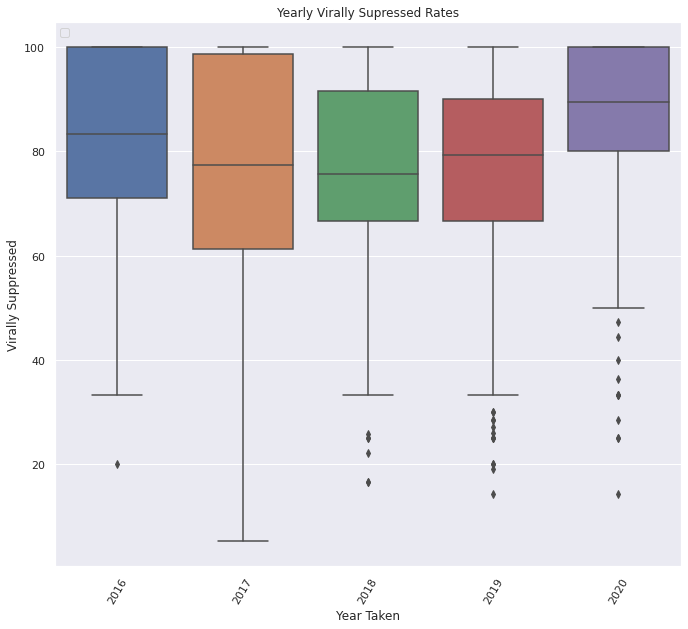

In [64]:
plot_boxplot_graph(df_vl,'EF_TAKEN_YEAR','VL_RATES_PERCENTAGE','Year Taken','Virally Suppressed','Yearly Virally Supressed Rates',hue=None)

No handles with labels found to put in legend.


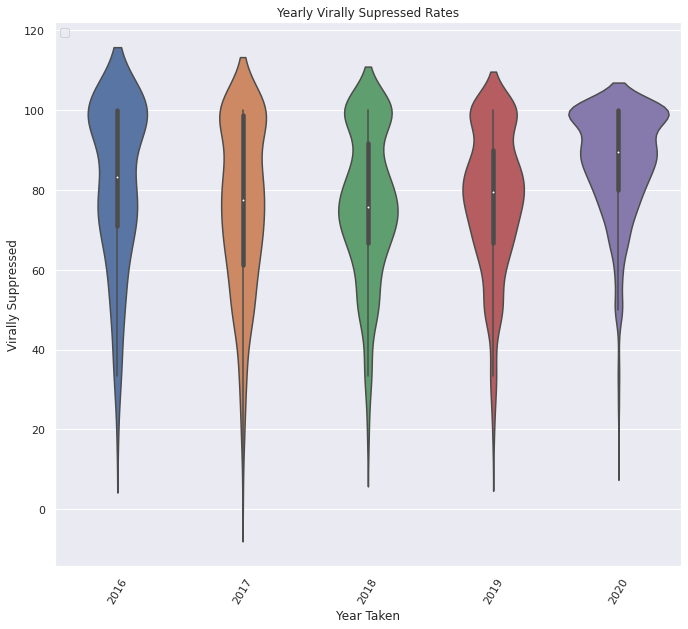

In [65]:
plot_violinplot_graph(df_vl,'EF_TAKEN_YEAR','VL_RATES_PERCENTAGE','Year Taken','Virally Suppressed','Yearly Virally Supressed Rates')

No handles with labels found to put in legend.


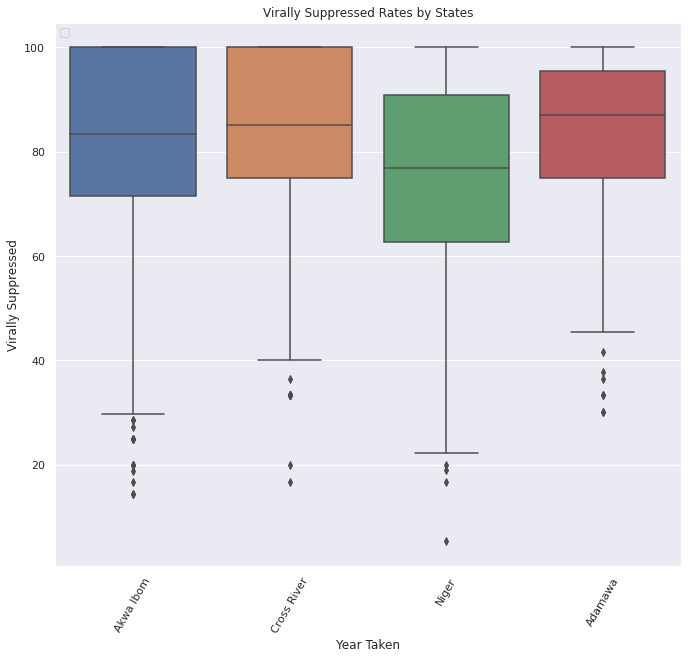

In [66]:
plot_boxplot_graph(df_vl,'State','VL_RATES_PERCENTAGE','Year Taken','Virally Suppressed','Virally Suppressed Rates by States',hue=None)

No handles with labels found to put in legend.


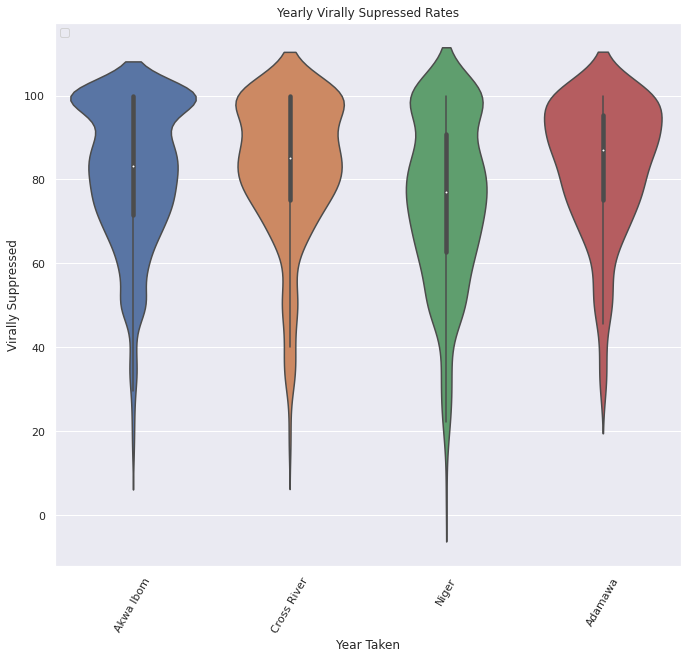

In [67]:
plot_violinplot_graph(df_vl,'State','VL_RATES_PERCENTAGE','Year Taken','Virally Suppressed','Yearly Virally Supressed Rates')

No handles with labels found to put in legend.


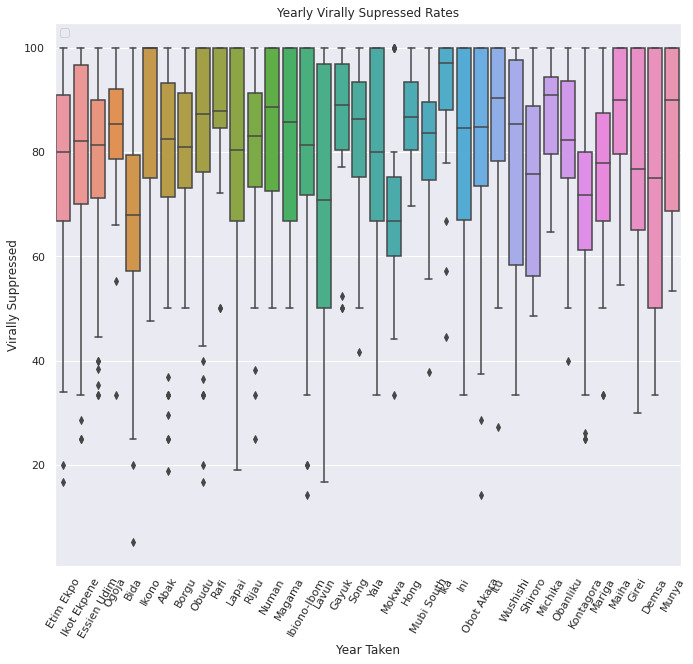

In [68]:
plot_boxplot_graph(df_vl,'L.G.A','VL_RATES_PERCENTAGE','Year Taken','Virally Suppressed','Yearly Virally Supressed Rates',hue=None)

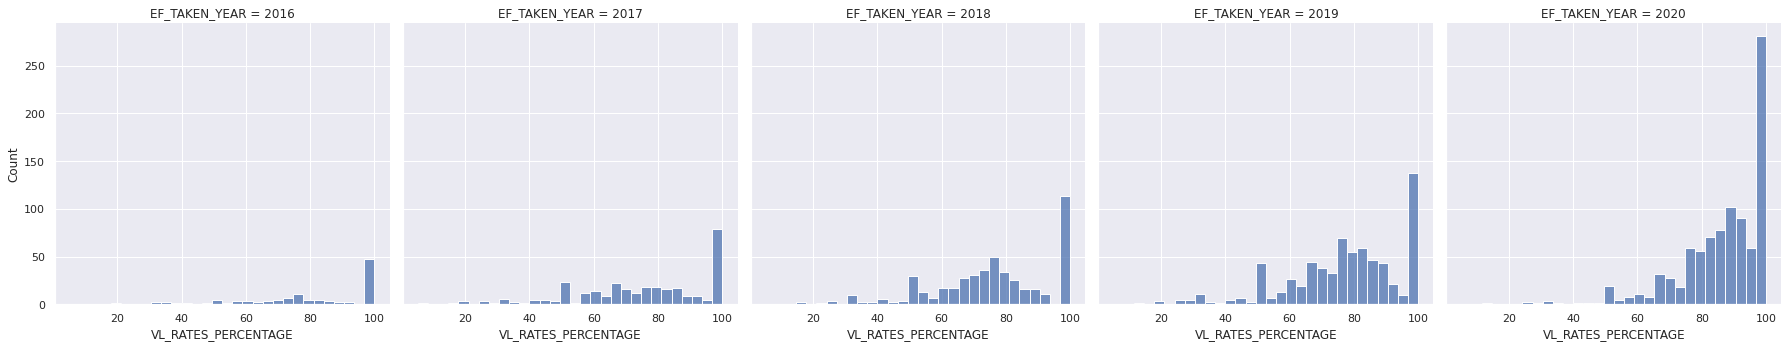

In [69]:
sns.displot(df_vl,x="VL_RATES_PERCENTAGE",col="EF_TAKEN_YEAR",bins=30)
sns.set(rc={'figure.figsize':(8,8)})

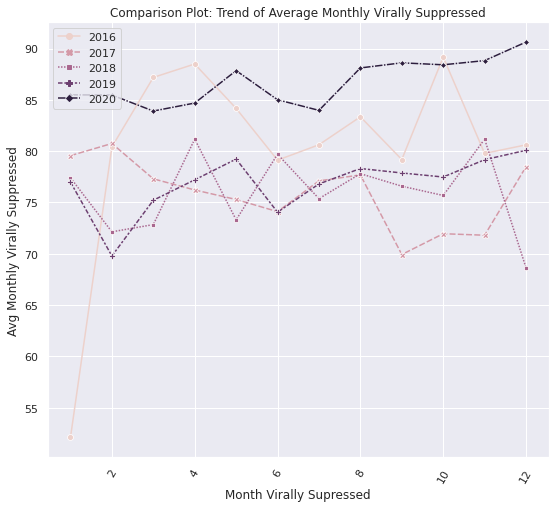

In [70]:
plot_line_graph(df_vl,'EF_TAKEN_MONTH','VL_RATES_PERCENTAGE','Month Virally Supressed','Avg Monthly Virally Suppressed','EF_TAKEN_YEAR','EF_TAKEN_YEAR')